# Preprocessing Data

Pipeline cho bộ dữ liệu đã gom theo topic trong cấu trúc thư mục:

```text
project_root/
  data_filtered/
    Ẩm thực/
      AT_VNE_1.txt
      ...
    Du lịch/
      DL_VNE_1.txt
      ...
    ... (21 topic)
```

Notebook này thực hiện 4 bước:
1. Load toàn bộ `.txt` trong từng topic, xử lý **duplicate** (theo nội dung text trong từng topic) và di chuyển file trùng vào thư mục `_duplicates` của topic đó.
2. **Length check**: nếu bài có độ dài `< 70` ký tự thì xem là quá ngắn, di chuyển vào thư mục `_too_short`.
3. Chọn **5% bài trong từng topic** làm sample để **spot checking** thủ công, xuất ra file `spot_check_samples.csv`.
4. **Imbalance check** giữa các topic sau khi làm sạch và vẽ line chart số bài theo topic.


In [1]:
# Cấu hình đường dẫn chính
from pathlib import Path

# Thư mục chứa dữ liệu
DATA_ROOT = Path("data")

DATA_ROOT.resolve()

WindowsPath('C:/Users/yello/PycharmProjects/NLP/data')

## 1. Import thư viện và hàm hỗ trợ


In [2]:
import os
import hashlib
import shutil
import random

import pandas as pd
import matplotlib.pyplot as plt

random.seed(42)
pd.set_option("display.max_colwidth", 200)

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return " ".join(text.split()).strip()

def file_hash(text: str) -> str:
    norm = normalize_text(text)
    return hashlib.md5(norm.encode("utf-8")).hexdigest()

DATA_ROOT.exists(), list(DATA_ROOT.iterdir())[:5]

(True,
 [WindowsPath('data/Bất động sản'),
  WindowsPath('data/Chứng khoán'),
  WindowsPath('data/Công nghệ'),
  WindowsPath('data/Du lịch'),
  WindowsPath('data/Gia đình')])

## 2. Load toàn bộ dữ liệu thành DataFrame

- Mỗi file `.txt` là một bài.
- `topic` = tên thư mục con (ví dụ `"Ẩm thực"`).
- `filename` = tên file.
- `file_path` = đường dẫn đầy đủ.
- `text` = nội dung bài.


In [3]:
rows = []

for topic_dir in DATA_ROOT.iterdir():
    if not topic_dir.is_dir():
        continue
    topic = topic_dir.name
    for txt_file in topic_dir.glob("*.txt"):
        try:
            with txt_file.open("r", encoding="utf-8", errors="ignore") as f:
                raw = f.read()
        except Exception as e:
            print(f"[WARN] Không đọc được file {txt_file}: {e}")
            continue

        # Loại NULL và một số control char dễ gây hư format Excel
        cleaned = (
            raw.replace("\x00", "")   # bỏ NULL giữa các ký tự
               .replace("\u200b", "") # zero-width space nếu có
        )

        text = cleaned.strip()

        rows.append({
            "topic": topic,
            "filename": txt_file.name,
            "file_path": str(txt_file),
            "text": text,
        })


df = pd.DataFrame(rows)
print("Số bài tổng cộng:", len(df))
df.head()

Số bài tổng cộng: 114114


,topic,filename,file_path,text
0,Bất động sản,BĐS_CAF_16.txt,data\Bất động sản\BĐS_CAF_16.txt,"Công ty Thương binh nặng Hòa Bình, doanh nghiệp gắn với tên tuổi doanh nhân ""Đường bia"", vừa công bố kết quả thử tải mô hình ""Đường cao tốc và đường sắt đô thị"" tích hợp đa tầng tại 321 Vĩnh Hưng ..."
1,Bất động sản,BĐS_CAF_17.txt,data\Bất động sản\BĐS_CAF_17.txt,"Những cái tên tiên phong Vingroup, Sun Group, Eurowindow Holding, Ecopark,...\n\nBản tin mới nhất của Hội Môi giới bất động sản Việt Nam (VARS) nêu, trong bối cảnh ô nhiễm môi trường ngày càng gia..."
2,Bất động sản,BĐS_CAF_18.txt,data\Bất động sản\BĐS_CAF_18.txt,"Mới đây, Phó Chủ tịch UBND tỉnh An Giang Ngô Công Thức chủ trì buổi làm việc với Công ty TNHH Mặt trời Phú Quốc (thành viên của Tập đoàn Sun Group) về tiến độ giải phóng mặt bằng các dự án trọng đ..."
3,Bất động sản,BĐS_CAF_19.txt,data\Bất động sản\BĐS_CAF_19.txt,"Ngày 11/12, Thường trực HĐND TP. Hà Nội cho biết, kỳ họp thứ 29 (kỳ họp chuyên đề) sẽ được tổ chức từ ngày 12-13/12/2025 để xem xét một số nội dung thuộc thẩm quyền.\n\nTheo đó, kỳ họp sẽ xem xét,..."
4,Bất động sản,BĐS_CAF_20.txt,data\Bất động sản\BĐS_CAF_20.txt,"Sở Xây dựng Hà Nội vừa thông báo kế hoạch tiếp nhận hồ sơ mua lại các căn hộ nhà ở xã hội đã cho thuê đủ thời hạn tại hai dự án trên địa bàn. Đây là nhóm căn hộ thuộc diện thuê – mua trước đây, na..."


## 3. Xử lý duplicate trong từng topic

Tiêu chí duplicate:
- Cùng `topic`.
- Cùng `text_hash` (hash của nội dung đã normalize).

Giữ lại bản xuất hiện đầu tiên, các bản trùng sau:
- Được di chuyển sang thư mục con `_duplicates` trong topic tương ứng.
- Không dùng trong `df_nodup` (dataset sạch sau bước này).


In [4]:
if df.empty:
    raise ValueError("DataFrame rỗng, kiểm tra lại DATA_ROOT.")

df["norm_text"] = df["text"].apply(normalize_text)
df["text_hash"] = df["norm_text"].apply(file_hash)

# Xác định duplicate trong từng topic
df["is_duplicate"] = df.duplicated(subset=["topic", "text_hash"], keep="first")

dups = df[df["is_duplicate"]].copy()
print("Số bài duplicate tìm được:", len(dups))
dups.groupby("topic")["filename"].count()

Số bài duplicate tìm được: 371


topic
Bất động sản            15
Giải trí                 1
Khoa học                 4
Kinh doanh               4
Nông nghiệp              5
Pháp luật                1
Sức khỏe                 4
Thế giới                 3
Thể thao                 3
Thời sự – Chính trị      2
Văn hóa                294
Đời sống                16
Ẩm thực                 19
Name: filename, dtype: int64

In [5]:
for row in dups.itertuples(index=False):
    file_path = Path(row.file_path)
    topic_dir = file_path.parent
    dup_dir = topic_dir / "_duplicates"
    dup_dir.mkdir(exist_ok=True)
    target_path = dup_dir / file_path.name
    if not target_path.exists():
        shutil.move(str(file_path), str(target_path))

df_nodup = df[~df["is_duplicate"]].copy().reset_index(drop=True)
print("Số bài sau khi bỏ duplicate:", len(df_nodup))
df_nodup.head()

Số bài sau khi bỏ duplicate: 113743


,topic,filename,file_path,text,norm_text,text_hash,is_duplicate
0,Bất động sản,BĐS_CAF_16.txt,data\Bất động sản\BĐS_CAF_16.txt,"Công ty Thương binh nặng Hòa Bình, doanh nghiệp gắn với tên tuổi doanh nhân ""Đường bia"", vừa công bố kết quả thử tải mô hình ""Đường cao tốc và đường sắt đô thị"" tích hợp đa tầng tại 321 Vĩnh Hưng ...","Công ty Thương binh nặng Hòa Bình, doanh nghiệp gắn với tên tuổi doanh nhân ""Đường bia"", vừa công bố kết quả thử tải mô hình ""Đường cao tốc và đường sắt đô thị"" tích hợp đa tầng tại 321 Vĩnh Hưng ...",cdf5fe021a1a2b5262f65537dbdbcf6b,False
1,Bất động sản,BĐS_CAF_17.txt,data\Bất động sản\BĐS_CAF_17.txt,"Những cái tên tiên phong Vingroup, Sun Group, Eurowindow Holding, Ecopark,...\n\nBản tin mới nhất của Hội Môi giới bất động sản Việt Nam (VARS) nêu, trong bối cảnh ô nhiễm môi trường ngày càng gia...","Những cái tên tiên phong Vingroup, Sun Group, Eurowindow Holding, Ecopark,... Bản tin mới nhất của Hội Môi giới bất động sản Việt Nam (VARS) nêu, trong bối cảnh ô nhiễm môi trường ngày càng gia tă...",dd0cf22f1aff586caaf4af5d9fba773e,False
2,Bất động sản,BĐS_CAF_18.txt,data\Bất động sản\BĐS_CAF_18.txt,"Mới đây, Phó Chủ tịch UBND tỉnh An Giang Ngô Công Thức chủ trì buổi làm việc với Công ty TNHH Mặt trời Phú Quốc (thành viên của Tập đoàn Sun Group) về tiến độ giải phóng mặt bằng các dự án trọng đ...","Mới đây, Phó Chủ tịch UBND tỉnh An Giang Ngô Công Thức chủ trì buổi làm việc với Công ty TNHH Mặt trời Phú Quốc (thành viên của Tập đoàn Sun Group) về tiến độ giải phóng mặt bằng các dự án trọng đ...",f5c49b09c65b509e7f2885942cddc348,False
3,Bất động sản,BĐS_CAF_19.txt,data\Bất động sản\BĐS_CAF_19.txt,"Ngày 11/12, Thường trực HĐND TP. Hà Nội cho biết, kỳ họp thứ 29 (kỳ họp chuyên đề) sẽ được tổ chức từ ngày 12-13/12/2025 để xem xét một số nội dung thuộc thẩm quyền.\n\nTheo đó, kỳ họp sẽ xem xét,...","Ngày 11/12, Thường trực HĐND TP. Hà Nội cho biết, kỳ họp thứ 29 (kỳ họp chuyên đề) sẽ được tổ chức từ ngày 12-13/12/2025 để xem xét một số nội dung thuộc thẩm quyền. Theo đó, kỳ họp sẽ xem xét, th...",ef6d35a32cfc224a309218169ac3dd9a,False
4,Bất động sản,BĐS_CAF_20.txt,data\Bất động sản\BĐS_CAF_20.txt,"Sở Xây dựng Hà Nội vừa thông báo kế hoạch tiếp nhận hồ sơ mua lại các căn hộ nhà ở xã hội đã cho thuê đủ thời hạn tại hai dự án trên địa bàn. Đây là nhóm căn hộ thuộc diện thuê – mua trước đây, na...","Sở Xây dựng Hà Nội vừa thông báo kế hoạch tiếp nhận hồ sơ mua lại các căn hộ nhà ở xã hội đã cho thuê đủ thời hạn tại hai dự án trên địa bàn. Đây là nhóm căn hộ thuộc diện thuê – mua trước đây, na...",fc31774ae6cb523d4cc37531d732cf50,False


## 4. Length check: bỏ bài quá ngắn (< 70 ký tự)

Bài nào `len(text) < 70`:
- Di chuyển sang thư mục `_too_short` trong topic tương ứng.
- Không dùng trong `df_clean`.


In [6]:
df_nodup["char_len"] = (
    df_nodup["norm_text"]
      .str.replace(" ", "", regex=False)
      .str.len()
)

too_short_mask = df_nodup["char_len"] < 70
short_df = df_nodup[too_short_mask].copy()
print("Số bài quá ngắn (<70 ký tự, không tính khoảng trắng):", len(short_df))
short_df.groupby("topic")["filename"].count()


Số bài quá ngắn (<70 ký tự, không tính khoảng trắng): 0


Series([], Name: filename, dtype: int64)

In [7]:
for row in short_df.itertuples(index=False):
    file_path = Path(row.file_path)
    topic_dir = file_path.parent
    short_dir = topic_dir / "_too_short"
    short_dir.mkdir(exist_ok=True)
    target_path = short_dir / file_path.name
    if not target_path.exists():
        shutil.move(str(file_path), str(target_path))

df_clean = df_nodup[~too_short_mask].copy().reset_index(drop=True)
print("Số bài sau khi lọc duplicate và length:", len(df_clean))
df_clean.head()

Số bài sau khi lọc duplicate và length: 113743


,topic,filename,file_path,text,norm_text,text_hash,is_duplicate,char_len
0,Bất động sản,BĐS_CAF_16.txt,data\Bất động sản\BĐS_CAF_16.txt,"Công ty Thương binh nặng Hòa Bình, doanh nghiệp gắn với tên tuổi doanh nhân ""Đường bia"", vừa công bố kết quả thử tải mô hình ""Đường cao tốc và đường sắt đô thị"" tích hợp đa tầng tại 321 Vĩnh Hưng ...","Công ty Thương binh nặng Hòa Bình, doanh nghiệp gắn với tên tuổi doanh nhân ""Đường bia"", vừa công bố kết quả thử tải mô hình ""Đường cao tốc và đường sắt đô thị"" tích hợp đa tầng tại 321 Vĩnh Hưng ...",cdf5fe021a1a2b5262f65537dbdbcf6b,False,3773
1,Bất động sản,BĐS_CAF_17.txt,data\Bất động sản\BĐS_CAF_17.txt,"Những cái tên tiên phong Vingroup, Sun Group, Eurowindow Holding, Ecopark,...\n\nBản tin mới nhất của Hội Môi giới bất động sản Việt Nam (VARS) nêu, trong bối cảnh ô nhiễm môi trường ngày càng gia...","Những cái tên tiên phong Vingroup, Sun Group, Eurowindow Holding, Ecopark,... Bản tin mới nhất của Hội Môi giới bất động sản Việt Nam (VARS) nêu, trong bối cảnh ô nhiễm môi trường ngày càng gia tă...",dd0cf22f1aff586caaf4af5d9fba773e,False,3863
2,Bất động sản,BĐS_CAF_18.txt,data\Bất động sản\BĐS_CAF_18.txt,"Mới đây, Phó Chủ tịch UBND tỉnh An Giang Ngô Công Thức chủ trì buổi làm việc với Công ty TNHH Mặt trời Phú Quốc (thành viên của Tập đoàn Sun Group) về tiến độ giải phóng mặt bằng các dự án trọng đ...","Mới đây, Phó Chủ tịch UBND tỉnh An Giang Ngô Công Thức chủ trì buổi làm việc với Công ty TNHH Mặt trời Phú Quốc (thành viên của Tập đoàn Sun Group) về tiến độ giải phóng mặt bằng các dự án trọng đ...",f5c49b09c65b509e7f2885942cddc348,False,2466
3,Bất động sản,BĐS_CAF_19.txt,data\Bất động sản\BĐS_CAF_19.txt,"Ngày 11/12, Thường trực HĐND TP. Hà Nội cho biết, kỳ họp thứ 29 (kỳ họp chuyên đề) sẽ được tổ chức từ ngày 12-13/12/2025 để xem xét một số nội dung thuộc thẩm quyền.\n\nTheo đó, kỳ họp sẽ xem xét,...","Ngày 11/12, Thường trực HĐND TP. Hà Nội cho biết, kỳ họp thứ 29 (kỳ họp chuyên đề) sẽ được tổ chức từ ngày 12-13/12/2025 để xem xét một số nội dung thuộc thẩm quyền. Theo đó, kỳ họp sẽ xem xét, th...",ef6d35a32cfc224a309218169ac3dd9a,False,1118
4,Bất động sản,BĐS_CAF_20.txt,data\Bất động sản\BĐS_CAF_20.txt,"Sở Xây dựng Hà Nội vừa thông báo kế hoạch tiếp nhận hồ sơ mua lại các căn hộ nhà ở xã hội đã cho thuê đủ thời hạn tại hai dự án trên địa bàn. Đây là nhóm căn hộ thuộc diện thuê – mua trước đây, na...","Sở Xây dựng Hà Nội vừa thông báo kế hoạch tiếp nhận hồ sơ mua lại các căn hộ nhà ở xã hội đã cho thuê đủ thời hạn tại hai dự án trên địa bàn. Đây là nhóm căn hộ thuộc diện thuê – mua trước đây, na...",fc31774ae6cb523d4cc37531d732cf50,False,1344


## 5. Spot checking: chọn mẫu thủ công cho 1 hoặc nhiều topic

- Bạn tự chỉ định:
  - Topic (hoặc danh sách topic) muốn kiểm tra.
  - Số lượng bài lấy mẫu mỗi topic.
- Kết quả lưu vào `spot_check_samples.csv` để mở bằng Excel / pandas và kiểm tra thủ công.


In [16]:
available_topics = sorted(df_clean["topic"].unique())
print("Các topic hiện có:", available_topics)

#Chọn 1 topic cần kiểm tra:
TOPICS_TO_CHECK = ["Du lịch", "Chứng khoán"]  # hoặc ["Du lịch", "Chứng khoán"]

#Số lượng bài muốn lấy mẫu mỗi topic:
N_SAMPLE_PER_TOPIC = 5

output_path = "spot_check_samples.xlsx"

spot_parts = []

for topic in TOPICS_TO_CHECK:
    if topic not in available_topics:
        print(f"[BỎ QUA] Topic '{topic}' không có trong df_clean.")
        continue

    group = df_clean[df_clean["topic"] == topic]
    n = len(group)
    if n == 0:
        print(f"[BỎ QUA] Topic '{topic}' hiện không còn bài nào sau khi lọc.")
        continue

    k = min(N_SAMPLE_PER_TOPIC, n)
    sample = group.sample(n=k, random_state=42)
    spot_parts.append(sample)
    print(f"Topic '{topic}': {n} bài, chọn {k} bài để spot check.")

if spot_parts:
    spot_df = pd.concat(spot_parts, ignore_index=True)
else:
    spot_df = pd.DataFrame(columns=df_clean.columns)

spot_out = spot_df[["topic", "filename", "file_path", "char_len", "text"]].copy()
with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    spot_out.to_excel(writer, sheet_name="spot_check", index=False)

    workbook  = writer.book
    worksheet = writer.sheets["spot_check"]

    n_rows, n_cols = spot_out.shape

    header_fmt = workbook.add_format({
        "font_name": "Ariel",   # hoặc Arial
        "font_size": 13,
        "bold": True,
        "valign": "vcenter",
        "text_wrap": True,
    })

    cell_fmt = workbook.add_format({
        "font_name": "Ariel",
        "font_size": 13,
        "valign": "vcenter",
        "text_wrap": True,
    })

    # header
    worksheet.set_row(0, None, header_fmt)

    # data rows
    for r in range(1, n_rows + 1):
        worksheet.set_row(r, None, cell_fmt)

    worksheet.set_column(0, n_cols - 1, 20, cell_fmt)


spot_out.head()


Các topic hiện có: ['Bất động sản', 'Chứng khoán', 'Công nghệ', 'Du lịch', 'Gia đình', 'Giao thông', 'Giáo dục', 'Giải trí', 'Khoa học', 'Khởi nghiệp', 'Kinh doanh', 'Nông nghiệp', 'Pháp luật', 'Sức khỏe', 'Thế giới', 'Thể thao', 'Thời sự – Chính trị', 'Văn hóa', 'Xã hội', 'Đời sống', 'Ẩm thực']
Topic 'Du lịch': 2608 bài, chọn 5 bài để spot check.
Topic 'Chứng khoán': 2513 bài, chọn 5 bài để spot check.


,topic,filename,file_path,char_len,text
0,Du lịch,DL_VNE_1517.txt,data\Du lịch\DL_VNE_1517.txt,222,"Tối 5/12, tại sảnh tầng cao trung tâm thương mại gần đó, nhiều người có mặt trước một giờ để ""săn"" khoảnh khắc Nhà thờ Đức Bà lên đèn. Đúng 18h45, trong tiếng chuông ngân, đèn từ tháp chuông đến n..."
1,Du lịch,DL_VNE_2235.txt,data\Du lịch\DL_VNE_2235.txt,221,"Đầu bếp mất 5 tiếng để làm xong các loại nhân cho bánh mì. Trong đó phần xíu mại chế biến từ cá thu sốt cà chua, nấu trong một tiếng. ""Dù có kích thước lớn nhưng món ăn vẫn giữ hương vị thơm ngon ..."
2,Du lịch,DL_DT_141.txt,data\Du lịch\DL_DT_141.txt,1641,"Từ bốn phương nhìn về khu vực trung tâm TP Hà Nội\n\nNếu lấy hồ Gươm làm khu vực nội đô - trung tâm TP Hà Nội, ở hướng Bắc là cầu Nhật Tân vượt sông Hồng dẫn vào thành phố.\n\nTrục đường Võ Chí Cô..."
3,Du lịch,DL_VNN_3046.txt,data\Du lịch\DL_VNN_3046.txt,2745,"Tối 7/12, đêm gala âm nhạc Việt Nam Hạnh Phúc diễn ra tại Quảng trường Đông Kinh Nghĩa Thục (Hà Nội), thu hút hàng nghìn người dân và du khách.\n\nLà điểm nhấn của ""Vietnam Happy Fest 2025 – Ngày ..."
4,Du lịch,DL_VNE_2979.txt,data\Du lịch\DL_VNE_2979.txt,2317,"Du l ch Campuchia b ng xe but\n\nng 6h sng, xe but b t  u ln bnh t TP HCM theo h ng c a kh u bin gi i M c Bi, Ty Ninh v i 21 hnh khch trn xe, trong  m t n a hnh khch l ng i Vi t Nam. Xe..."


## 6. Imbalance check giữa các topic

Đếm số bài còn lại sau khi làm sạch và vẽ line chart.


In [11]:
# Đếm số bài theo topic
topic_counts = df_clean.groupby("topic").size().sort_index()
topic_counts

topic
Bất động sản            2492
Chứng khoán             2513
Công nghệ               6953
Du lịch                 2608
Gia đình                2838
Giao thông              1116
Giáo dục                3464
Giải trí                5071
Khoa học                4906
Khởi nghiệp             2943
Kinh doanh              8389
Nông nghiệp             3371
Pháp luật               7204
Sức khỏe                9182
Thế giới                9527
Thể thao               11444
Thời sự – Chính trị    11215
Văn hóa                 8386
Xã hội                  1472
Đời sống                6165
Ẩm thực                 2484
dtype: int64

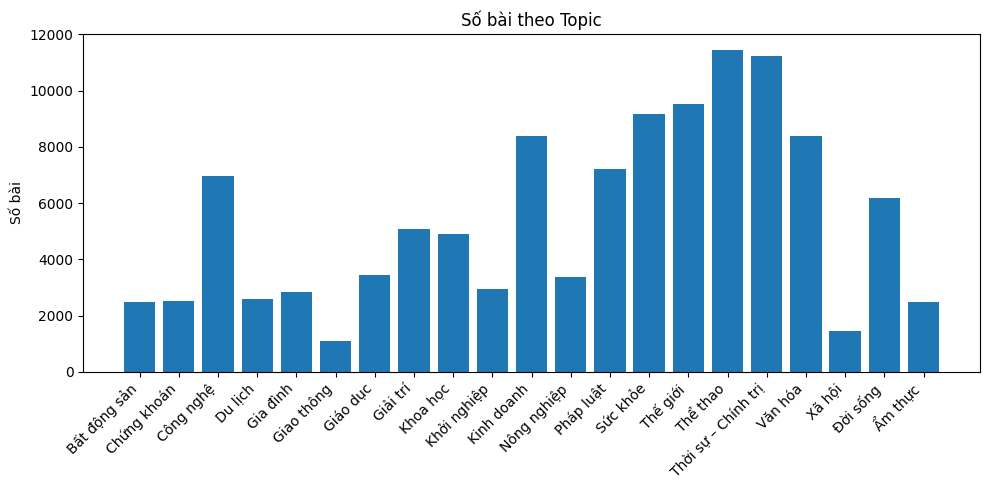

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(topic_counts.index, topic_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Số bài")
plt.title("Số bài theo Topic")
plt.tight_layout()
plt.show()